# Visualize & Analyze Word2Vec Model

https://github.com/lknelson/measuring_intersectionality/blob/main/scripts/01_measuringintersectionality_reproduceanalysis.ipynb

In [1]:
import sys, os, random, warnings, pickle, nltk, gensim
import pandas as pd
import numpy as np

# Primary visualizations
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
import plotly.express as px

# PCA visualization
from scipy.spatial.distance import cosine
from nltk.cluster import KMeansClusterer
from sklearn import cluster, metrics
from sklearn.metrics import pairwise, adjusted_rand_score
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA, NMF
from mpl_toolkits.mplot3d import Axes3D

# Ignore warnings.
warnings.filterwarnings("ignore")

# Declare absolute path.
abs_dir = "/Users/quinn.wi/Documents/"

# Load model.
model = gensim.models.KeyedVectors.load_word2vec_format(abs_dir + '/Data/Output/WordVectors/jqa_w2v.txt')

## Data Check

In [2]:
print(model.similarity('boston', 'federalist'))
print(model.similarity('british', 'federalist'))

print ('\nWords most similar to "home":\n', [word for word, score in model.most_similar(['home'])], '\n')

print ('Words most similar to "work":\n', [word for word, score in model.most_similar(['work'])], '\n')

print ('Word most similar to "freedom + congress - britain":\n', 
       model.most_similar(positive = ['freedom', 'congress'], negative = ['britain'], topn = 4))

0.29898983
0.19474216

Words most similar to "home":
 ['retired', 'sunset', 'staid', 'midnight', 'dusk', 'supped', 'dark', 'suppd', 'homeward', 'gardners'] 

Words most similar to "work":
 ['larger', 'materials', 'confusion', 'method', 'tomb', 'incomplete', 'agricola', 'researches', 'metamorphoses', 'research'] 

Word most similar to "freedom + congress - britain":
 [('incorporation', 0.5814316272735596), ('capacities', 0.5407549142837524), ('ordinary', 0.5385777354240417), ('christians', 0.532991886138916)]


## KMeans Clustering

In [4]:
%%time

X = model[model.key_to_index]

clusters = 100

kclusterer = KMeansClusterer(clusters, distance = nltk.cluster.util.cosine_distance, repeats = 25)
assigned_clusters = kclusterer.cluster(X, assign_clusters = True)

kmeans = cluster.KMeans(n_clusters = clusters)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

words = list(model.key_to_index)
cluster_dict = {}

for i, word in enumerate(words):
    cluster_dict[word] = str(assigned_clusters[i])

CPU times: user 36min 25s, sys: 12.2 s, total: 36min 37s
Wall time: 36min 24s


In [5]:
%%time

with open(abs_dir + '/Data/Output/WordVectors/jqa_w2v_kmeans-clusters.pkl', 'wb') as f:
    pickle.dump(cluster_dict, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 1.37 ms, sys: 940 µs, total: 2.31 ms
Wall time: 1.54 ms


## PCA

In [10]:
%%time

X = model[model.key_to_index]

pca = PCA(n_components = 3).fit_transform(X)

Y = TSNE(n_components=3, random_state=0, perplexity=15).fit_transform(pca)
    
# Sets everything up to plot
tsne_data = pd.DataFrame({'words': [k for k in model.key_to_index],
                          'cluster': [v for v in cluster_dict.values()],
                          'x': [x for x in Y[:, 0]],
                          'y': [y for y in Y[:, 1]],
                          'z': [z for z in Y[:, 2]]})

tsne_data

CPU times: user 4min 34s, sys: 3.82 s, total: 4min 37s
Wall time: 25 s


,words,cluster,x,y,z
0,the,44,2.162139,1.381530,-8.885786
1,of,44,0.763669,-2.519371,-7.895419
2,to,59,5.348395,-4.312669,1.419236
3,and,48,-3.969245,1.386129,3.033996
4,a,76,-3.997279,-1.146491,-1.529428
...,...,...,...,...,...
4507,magistrate,42,2.897877,3.220476,-2.905418
4508,appearing,19,7.317514,5.329947,0.630519
4509,suspect,24,8.299293,0.127037,5.266593
4510,relaxation,13,-2.615110,7.873173,1.391250


In [7]:
%%time

tsne_data.to_csv(abs_dir + '/Data/Output/WordVectors/jqa_w2v_tsne-coordinates.csv', sep = ',', index = False)

CPU times: user 28.3 ms, sys: 2.62 ms, total: 31 ms
Wall time: 31.7 ms


## t-SNE based on Clusters

KeyError: 0

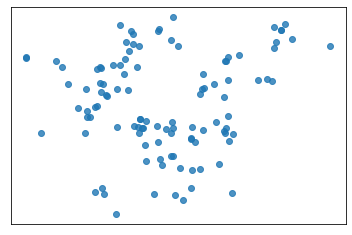

In [37]:
%%time

def construct_graph(data, word):
    fig, _ = plt.subplots()
    
    
    sel_cluster = data.query('words == @word')['cluster'].values[0]
    
    dff = data.query('cluster == @sel_cluster')
    
    # Basic plot
    p1 = sns.regplot(data = dff,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o")
            
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("")
    plt.ylabel("")

    # add annotations one by one with a loop
    for line in range(0, dff.shape[0]):
         p1.text(dff['x'][line],
                 dff['y'][line],
                 ' ' + data['words'][line].title(),
                 horizontalalignment = 'center', 
                 verticalalignment = 'bottom',
                 size = 'small', 
                 color = 'gray', 
                 weight = 'normal')
    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    
    return fig

construct_graph(tsne_data, 'work')

## t-SNE with User Control over Number of Data Points

CPU times: user 302 ms, sys: 6.49 ms, total: 309 ms
Wall time: 62.6 ms


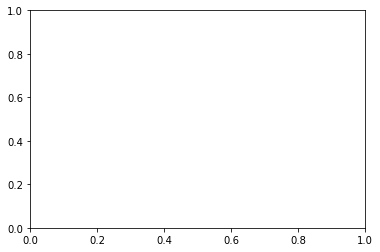

In [41]:
%%time

def construct_graph(data, word, topn):
    fig, _ = plt.subplots()
    
    word_list = []
    for i in model.most_similar([word], topn = topn):
        word_list.append(i[0])
    
    dff = data[data.words.isin(word_list)]
    
    fig = px.scatter_3d(dff, x = 'x', y = 'y', z = 'z', text = 'words')
    
    return fig

construct_graph(tsne_data, 'work', 5)

## PCA Visualization

In [ ]:

def tuple_to_dict(mytuple):
    """
    Input a tuple, output a dictionary
    """
    
    mydict = {}
    for key, value in mytuple:
        if key not in mydict:
            mydict[key] = value
    return mydict


In [ ]:
%%time

count = len(model)
n = 50

#50 words with highest cosine similarity to the five social institutions

polity = model.most_similar(['nation', 'state'], topn=count)
polity_dict = tuple_to_dict(polity)
polity_words = [word for word, score in polity][:n]

authority = model.most_similar(['authority'], topn=count)
authority_dict = tuple_to_dict(authority)
authority_words = [word for word, score in authority][:n]

# domestic = model.most_similar(['home', 'children'], topn=count)
# domestic_dict = tuple_to_dict(domestic)
# domestic_words = [word for word, score in domestic][:n]

# Create dataframe of main model data for easier visualization
rows = polity_words + authority_words

keyword_dict = {}
keyword_dict['polity'] = polity_dict
keyword_dict['authority'] = authority_dict
# keyword_dict['domestic'] = domestic_dict

df = pd.DataFrame(keyword_dict)
df = df.loc[rows]
df[''] = ''

# Domains
for word in polity_words:
    df.loc[word, ''] = 'Polity Words'

for word in authority_words:
    df.loc[word, ''] = 'Authority Words'

# for word in domestic_words:
#     df.loc[word, ''] = 'Domestic Words'


    
df_mds = df[['polity', 'authority']]
df_mds['polity'] = 1 - df_mds['polity']
df_mds['authority'] = 1 - df_mds['authority']
# df_mds['domestic'] = 1 - df_mds['domestic']

feat_cols = ['polity', 'authority'] #, 'domestic']

np.random.seed(42)
rndperm = np.random.permutation(df_mds.shape[0])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_mds[feat_cols].values)

df_mds['pcaone'] = pca_result[:,0]
df_mds['pcatwo'] = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

df_mds

In [ ]:
%%time

sns.set_style("whitegrid", {'axes.grid' : False})

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

palette = sns.color_palette("Set1", 4)

plt.figure(figsize=(25,12))

fig = sns.scatterplot(
    x = "pcaone",
    y = "pcatwo",
#     hue = "",
    palette = palette,
    data = df_mds,
    hue_order = ['polity', 'authority'],
    legend = "full",
    alpha = 0.8,
    s = 100
)

plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")

fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
fig.spines['left'].set_visible(False)

# add annotations one by one with a loop
for line in range(0, df_mds.shape[0]):
     fig.text(df_mds.pcaone[line], 
             df_mds.pcatwo[line], 
             df_mds.index[line], 
             horizontalalignment = 'center', 
             size = 'small', 
             color = 'gray', 
             weight = 'normal')
        
fig.legend(loc = 'upper center', 
            bbox_to_anchor = (0.5, -0.05), 
            ncol = 5,
            fontsize = 'large',
            markerscale = 4,
            frameon = False,
            )